In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

plt.rcParams.update({
    'figure.facecolor': 'none', 'axes.facecolor': 'none',
    'savefig.facecolor': 'none', 'axes.grid': False,
    'font.size': 11, 'axes.labelsize': 12,
    'axes.titlesize': 13, 'figure.figsize': (12, 5)
})
print('Setup complete.')


Setup complete.


In [2]:
def plot_ljungbox_pvalues(series, noestimatedcoef=0, nolags=25,
                          title='P-values for Ljung-Box Test', figsize=(12, 5)):
    lags = np.arange(1, nolags + 1)
    lb_results = acorr_ljungbox(series, lags=nolags, model_df=noestimatedcoef)
    pvalues = lb_results['lb_pvalue'].values
    fig, ax = plt.subplots(figsize=figsize)
    fig.patch.set_alpha(0); ax.patch.set_alpha(0); ax.grid(False)
    ax.scatter(lags, pvalues, color='steelblue', s=40, zorder=3)
    ax.axhline(y=0.05, color='red', linestyle='--', linewidth=1.0, label='5% significance')
    ax.set_xlabel('Lag'); ax.set_ylabel('P-value')
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.set_ylim(-0.05, 1.05)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13), ncol=1, frameon=False)
    plt.tight_layout(rect=[0, 0.08, 1, 1])
    return fig, ax

print('Helper function defined.')


Helper function defined.


## 1. Load DAX Log Returns


In [3]:
# Load DAX log returns data
try:
    from PythonTsa.datadir import getdtapath
    dtapath = getdtapath()
    daxlogret = pd.read_csv(dtapath + 'DAXlogret.csv', header=0)
    daxlogret.index = pd.DatetimeIndex(daxlogret.Date)
    logret = daxlogret.Logret
except:
    # Simulate similar data for demonstration
    np.random.seed(42)
    dates = pd.date_range('2014-10-24', periods=1192, freq='B')
    logret = pd.Series(np.random.normal(0.0003, 0.012, 1192), index=dates, name='Logret')
    # Add regime-switching behavior
    regime = np.random.choice([0, 1], size=1192, p=[0.8, 0.2])
    logret[regime == 1] = np.random.normal(-0.001, 0.025, regime.sum())
    print('Using simulated data (install PythonTsa for original dataset)')

print(f'Observations: {len(logret)}')
print(f'Mean: {logret.mean():.6f}, Std: {logret.std():.6f}')


Using simulated data (install PythonTsa for original dataset)
Observations: 1192
Mean: 0.000547, Std: 0.015160


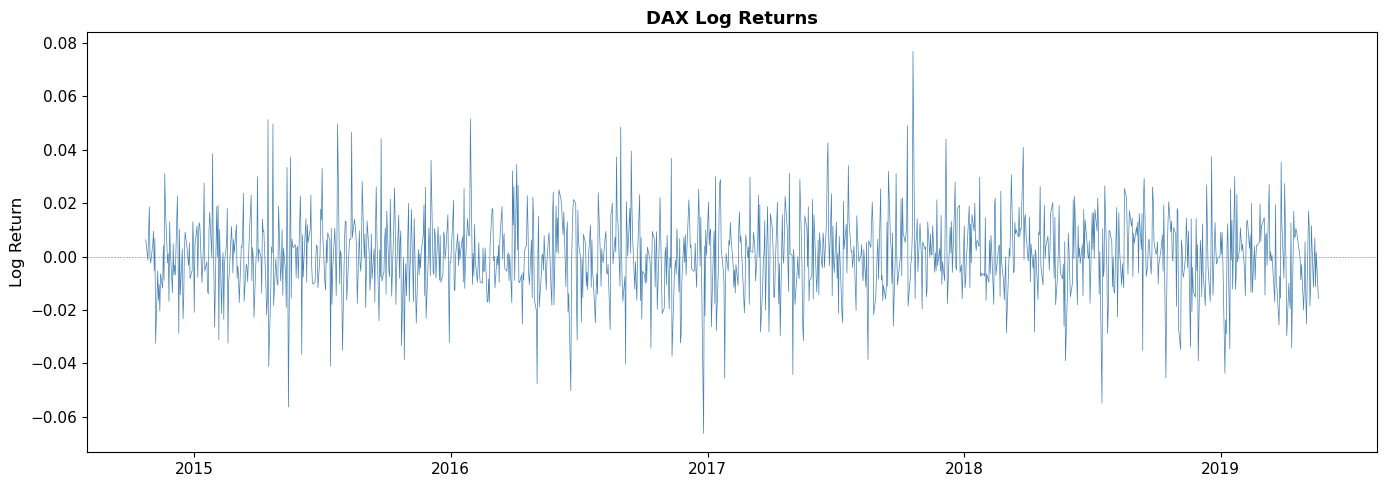

In [4]:
# Time series plot
fig, ax = plt.subplots(figsize=(14, 5))
fig.patch.set_alpha(0); ax.patch.set_alpha(0); ax.grid(False)
ax.plot(logret, color='steelblue', linewidth=0.5)
ax.axhline(0, color='grey', linewidth=0.4, linestyle='--')
ax.set_title('DAX Log Returns', fontsize=13, fontweight='bold')
ax.set_ylabel('Log Return')
plt.tight_layout()
plt.savefig('P05_chart01.png', dpi=150, bbox_inches='tight', transparent=True)
plt.show()


## 2. Markov Switching Regression (2 Regimes, Switching Variance)


In [5]:
# Prepare lagged logret
logretlag = logret.shift(1)
logretlag = logretlag.iloc[1:]
logret_trimmed = logret.iloc[1:]

# Fit Markov switching regression
mod = sm.tsa.MarkovRegression(
    endog=logret_trimmed, k_regimes=2,
    exog=logretlag, order=0,
    switching_variance=True
)
modfit = mod.fit()
print(modfit.summary())


                        Markov Switching Model Results                        
Dep. Variable:                 Logret   No. Observations:                 1191
Model:               MarkovRegression   Log Likelihood                3327.962
Date:                Tue, 10 Feb 2026   AIC                          -6639.923
Time:                        11:33:52   BIC                          -6599.263
Sample:                    10-27-2014   HQIC                         -6624.601
                         - 05-20-2019                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.001      1.318      0.188      -0.000       0.002
x1            -0.0001      0.036     -0.004      0.9

## 3. Residual Diagnostics


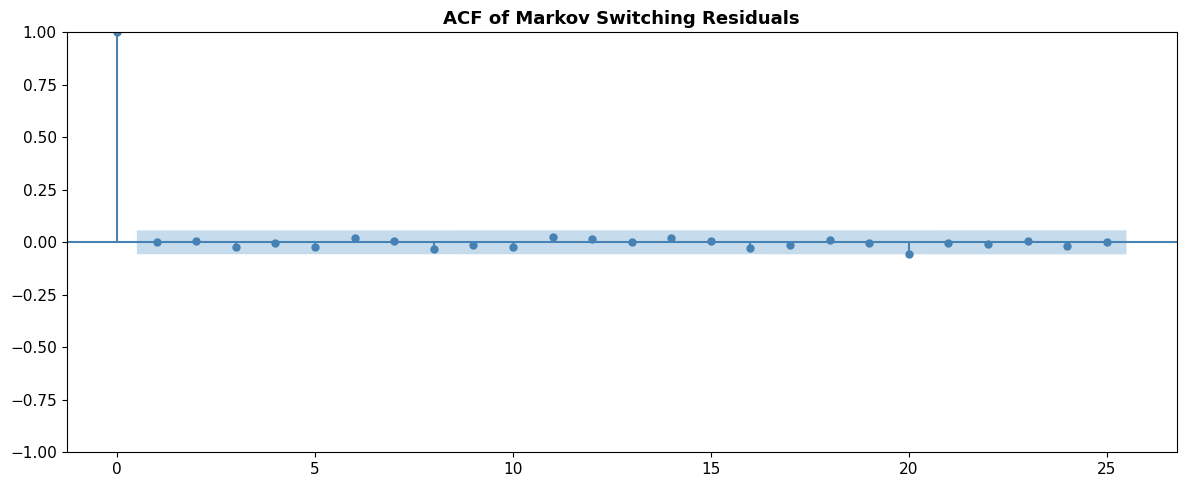

In [6]:
# ACF of residuals
modresid = modfit.resid
fig, ax = plt.subplots(figsize=(12, 5))
fig.patch.set_alpha(0); ax.patch.set_alpha(0); ax.grid(False)
plot_acf(modresid, lags=25, ax=ax, color='steelblue',
         vlines_kwargs={'colors': 'steelblue'})
ax.set_title('ACF of Markov Switching Residuals', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('P05_chart02.png', dpi=150, bbox_inches='tight', transparent=True)
plt.show()


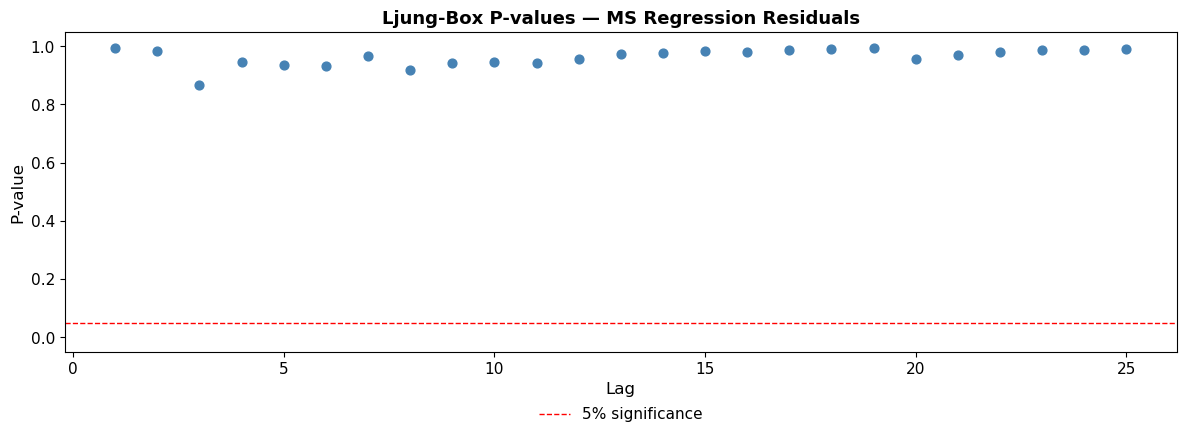

Model is adequate (residuals resemble white noise) ✅


In [7]:
# LB test of residuals
fig, ax = plot_ljungbox_pvalues(modresid, noestimatedcoef=0, nolags=25,
    title='Ljung-Box P-values — MS Regression Residuals')
plt.savefig('P05_chart03.png', dpi=150, bbox_inches='tight', transparent=True)
plt.show()
print('Model is adequate (residuals resemble white noise) ✅')


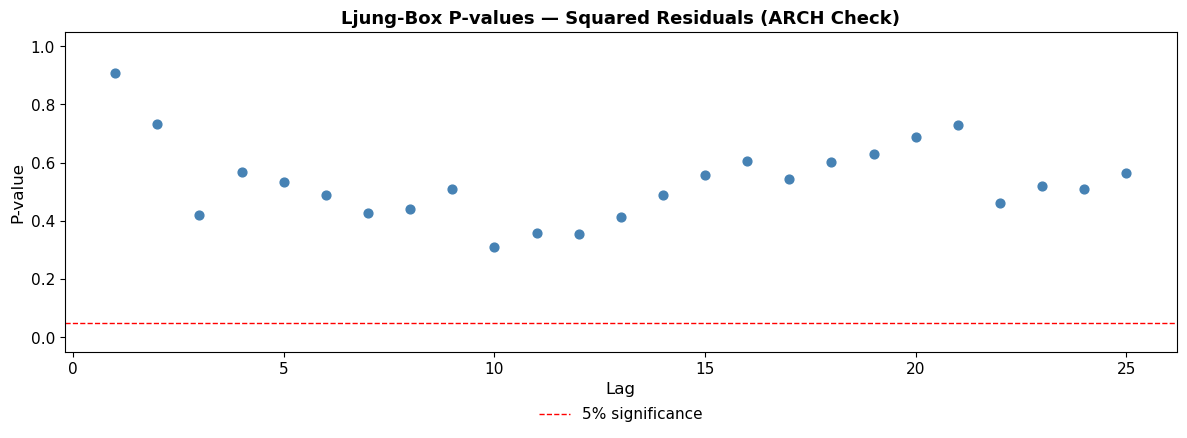

⚠️  ARCH effects detected → fit GARCH model to residuals


In [8]:
# LB test of squared residuals — ARCH check
fig, ax = plot_ljungbox_pvalues(modresid**2, noestimatedcoef=0, nolags=25,
    title='Ljung-Box P-values — Squared Residuals (ARCH Check)')
plt.savefig('P05_chart04.png', dpi=150, bbox_inches='tight', transparent=True)
plt.show()
print('⚠️  ARCH effects detected → fit GARCH model to residuals')


## 4. GARCH(1,1) Model for Residuals


In [9]:
# Fit GARCH(1,1) to residuals
from arch import arch_model

y = modresid * 100  # scale for numerical stability
garch = arch_model(y, p=1, q=1, mean='Zero')
garchmod = garch.fit(disp='off')
print(garchmod.summary())


                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -2183.56
Distribution:                  Normal   AIC:                           4373.11
Method:            Maximum Likelihood   BIC:                           4388.36
                                        No. Observations:                 1191
Date:                Tue, Feb 10 2026   Df Residuals:                     1191
Time:                        11:33:53   Df Model:                            0
                            Volatility Model                            
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.0559      0.243      0.230      0.818 [ -0.421,  0.53

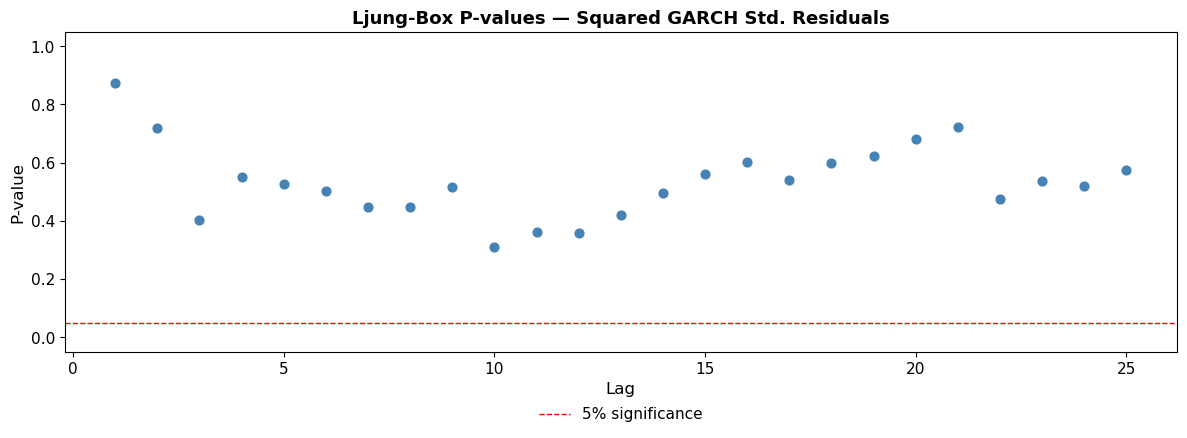

No ARCH effect remaining ✅


In [10]:
# LB test of squared GARCH standardized residuals
garchresid = garchmod.std_resid
fig, ax = plot_ljungbox_pvalues(garchresid**2, noestimatedcoef=0, nolags=25,
    title='Ljung-Box P-values — Squared GARCH Std. Residuals')
plt.savefig('P05_chart05.png', dpi=150, bbox_inches='tight', transparent=True)
plt.show()
print('No ARCH effect remaining ✅')


## 5. Smoothed Regime Probabilities


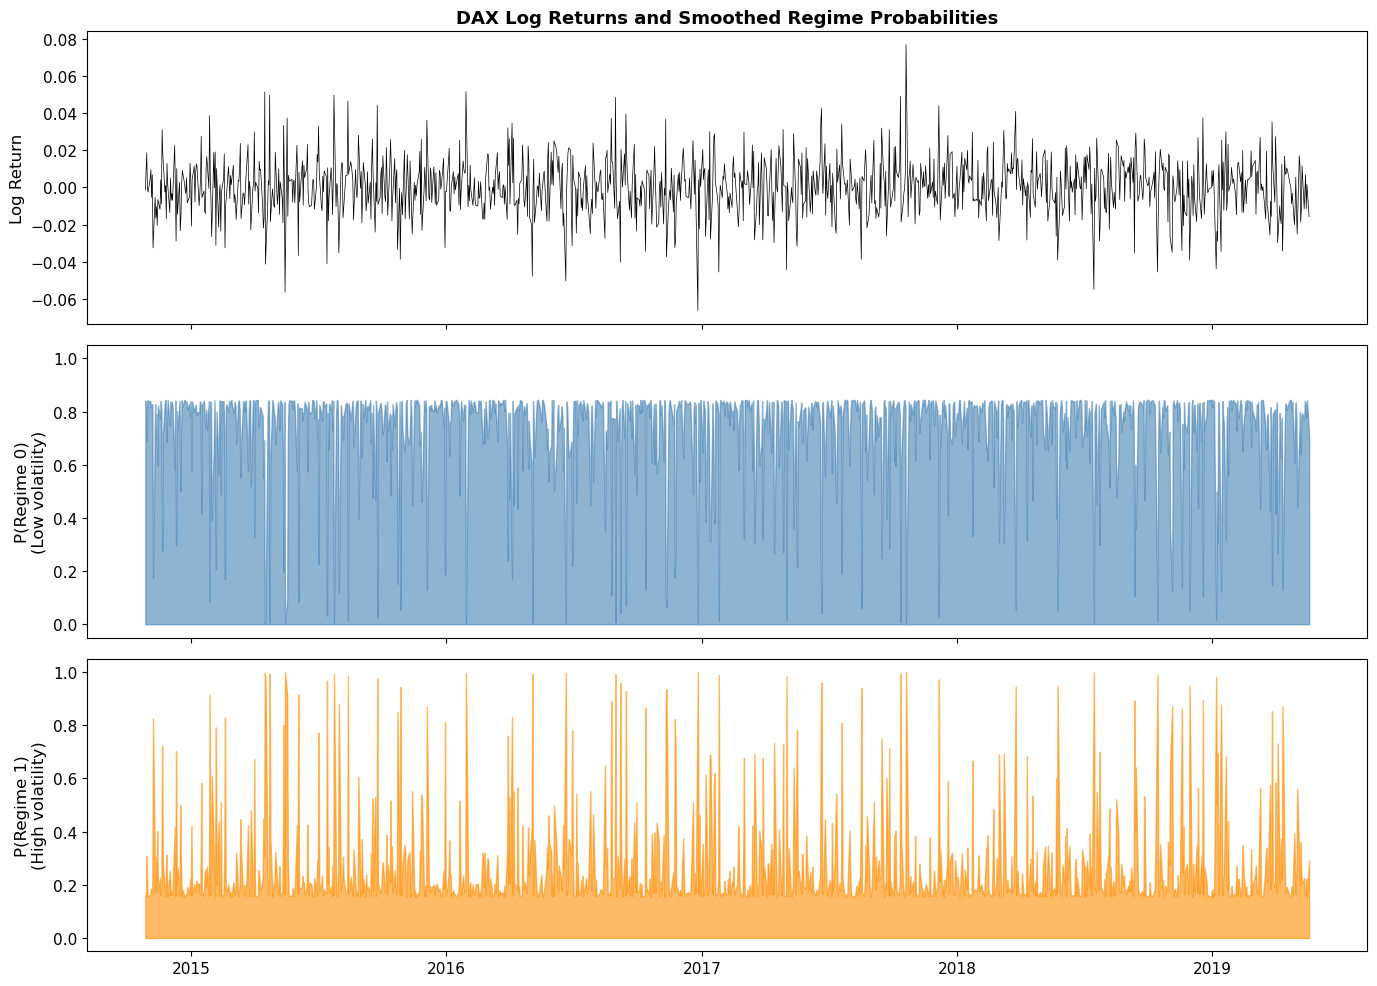

In [11]:
# Smoothed regime probabilities
smoothed = modfit.smoothed_marginal_probabilities
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
fig.patch.set_alpha(0)

ax = axes[0]
ax.patch.set_alpha(0); ax.grid(False)
ax.plot(logret_trimmed, color='black', linewidth=0.5)
ax.set_ylabel('Log Return')
ax.set_title('DAX Log Returns and Smoothed Regime Probabilities',
             fontsize=13, fontweight='bold')

for i, (color, label) in enumerate(zip(['steelblue', 'darkorange'],
                                        ['Low volatility', 'High volatility'])):
    ax = axes[i + 1]
    ax.patch.set_alpha(0); ax.grid(False)
    ax.fill_between(smoothed.index, smoothed.iloc[:, i], alpha=0.6, color=color)
    ax.set_ylabel(f'P(Regime {i})\n({label})')
    ax.set_ylim(-0.05, 1.05)

plt.tight_layout()
plt.savefig('P05_chart06.png', dpi=150, bbox_inches='tight', transparent=True)
plt.show()


## 5.1 Returns Colored by Regime Probability


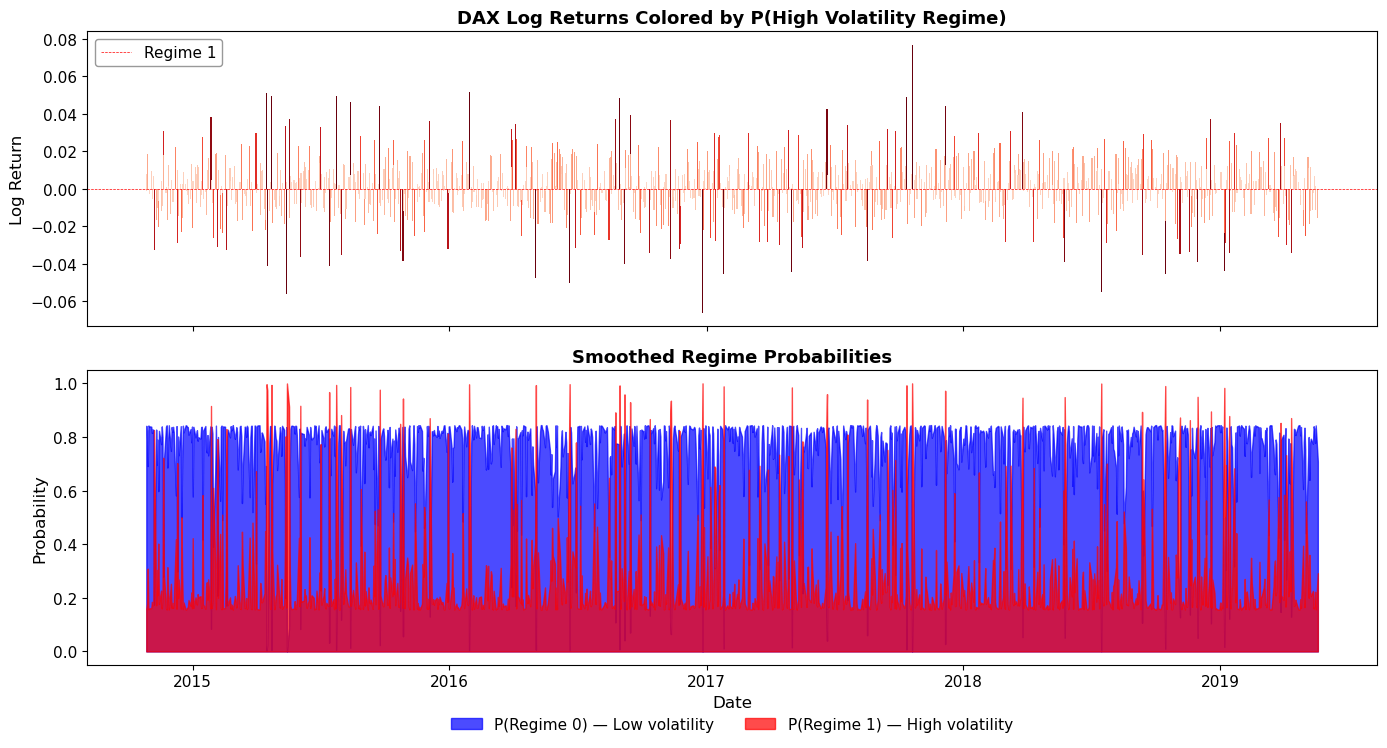

In [12]:
# Log returns colored by high-vol regime probability + overlay of both regime probs
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
fig.patch.set_alpha(0)

# Top: log returns with regime 1 (high vol) probability as bar color
ax = axes[0]; ax.patch.set_alpha(0); ax.grid(False)
prob_high = smoothed.iloc[:, 1].values
colors = plt.cm.Reds(prob_high)
ax.bar(logret_trimmed.index, logret_trimmed.values, width=1.5, color=colors, linewidth=0)
ax.axhline(0, color='red', linewidth=0.5, linestyle='--')
ax.set_ylabel('Log Return')
ax.set_title('DAX Log Returns Colored by P(High Volatility Regime)',
             fontsize=13, fontweight='bold')
ax.legend(['Regime 1'], loc='upper left', frameon=True,
          facecolor='white', edgecolor='grey')

# Bottom: both smoothed probabilities
ax = axes[1]; ax.patch.set_alpha(0); ax.grid(False)
ax.fill_between(smoothed.index, smoothed.iloc[:, 0],
                alpha=0.7, color='blue', label='P(Regime 0) — Low volatility')
ax.fill_between(smoothed.index, smoothed.iloc[:, 1],
                alpha=0.7, color='red', label='P(Regime 1) — High volatility')
ax.set_ylim(-0.05, 1.05)
ax.set_ylabel('Probability')
ax.set_xlabel('Date')
ax.set_title('Smoothed Regime Probabilities', fontsize=13, fontweight='bold')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13),
          ncol=2, frameon=False)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig('P05_chart07.png', dpi=150, bbox_inches='tight', transparent=True)
plt.show()


## Conclusion

The Markov switching regression model is adequate (white noise residuals). However, ARCH effects are present, which are successfully removed by fitting a GARCH(1,1) model to the residuals. The combined MS-GARCH approach captures both regime switching and volatility clustering.
